In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.sql import functions as F
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


In [2]:
# Initialize Spark session
spark = SparkSession.builder \
    .appName("Fraud Detection") \
    .getOrCreate()

In [3]:
indexer = StringIndexer(inputCol='type', outputCol='type_index')

# Select features for the model (you can adjust this based on your needs)
feature_cols = ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'type_index']
assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')

# Create a pipeline
pipeline = Pipeline(stages=[indexer, assembler])

In [4]:
from pyspark.ml.classification import RandomForestClassificationModel

# Load the Random Forest model
model = RandomForestClassificationModel.load("fraud_detection_model_V2")  # Replace with the actual path


In [9]:
def predict_fraud(input_data):
    # Create a DataFrame from the input
    input_df = spark.createDataFrame([input_data], schema=['step', 'type', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest'])

    # Transform the input
    input_transformed = pipeline.fit(input_df).transform(input_df)
    
    # Make predictions
    prediction = model.transform(input_transformed)
    
    return prediction.select('prediction').collect()[0][0]

# Example usage
user_input = [355, 'Debit', 900, 9000, 8100, 7100, 8000]  # Example input
result = predict_fraud(user_input)
print("Prediction:", "Fraud" if result == 1 else "Not Fraud")

Prediction: Not Fraud


In [1]:
from pyspark.sql import SparkSession

# Initialize Spark session
spark = SparkSession.builder \
    .appName("Accuracyreport") \
    .getOrCreate()

# Load the dataset
df = spark.read.csv('Synthetic_Financial_datasets_log.csv', header=True, inferSchema=True)

# Show the schema
df.printSchema()


root
 |-- step: integer (nullable = true)
 |-- type: string (nullable = true)
 |-- amount: double (nullable = true)
 |-- nameOrig: string (nullable = true)
 |-- oldbalanceOrg: double (nullable = true)
 |-- newbalanceOrig: double (nullable = true)
 |-- nameDest: string (nullable = true)
 |-- oldbalanceDest: double (nullable = true)
 |-- newbalanceDest: double (nullable = true)
 |-- isFraud: integer (nullable = true)
 |-- isFlaggedFraud: integer (nullable = true)



In [2]:
from pyspark.sql.functions import col
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline

# Index the categorical column 'type'
indexer = StringIndexer(inputCol='type', outputCol='type_index')

# Select features for the model (you can adjust this based on your needs)
feature_cols = ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'type_index']
assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')

# Create a pipeline
pipeline = Pipeline(stages=[indexer, assembler])
df_transformed = pipeline.fit(df).transform(df)

# Show transformed data
df_transformed.select('features', 'isFraud').show()


+--------------------+-------+
|            features|isFraud|
+--------------------+-------+
|[1.0,9839.64,1701...|      0|
|[1.0,1864.28,2124...|      0|
|[1.0,181.0,181.0,...|      1|
|[1.0,181.0,181.0,...|      1|
|[1.0,11668.14,415...|      0|
|[1.0,7817.71,5386...|      0|
|[1.0,7107.77,1831...|      0|
|[1.0,7861.64,1760...|      0|
|[1.0,4024.36,2671...|      0|
|[1.0,5337.77,4172...|      0|
|[1.0,9644.94,4465...|      0|
|[1.0,3099.97,2077...|      0|
|[1.0,2560.74,5070...|      0|
|[1.0,11633.76,101...|      0|
|[1.0,4098.78,5032...|      0|
|[1.0,229133.94,15...|      0|
|[1.0,1563.82,450....|      0|
|[1.0,1157.86,2115...|      0|
|[1.0,671.64,15123...|      0|
|[1.0,215310.3,705...|      0|
+--------------------+-------+
only showing top 20 rows



In [3]:
train_data, test_data = df_transformed.randomSplit([0.8, 0.2], seed=42)


In [5]:
from pyspark.ml.classification import RandomForestClassificationModel

# Load the Random Forest model
model = RandomForestClassificationModel.load("fraud_detection_model_V2")  # Replace with the actual path


In [6]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
# Make predictions on the test data
predictions = model.transform(test_data)
# Binary evaluator for areaUnderROC
binary_evaluator = BinaryClassificationEvaluator(labelCol="isFraud", rawPredictionCol="rawPrediction", metricName="areaUnderROC")

# Multiclass evaluator for precision, recall, and F1 score
precision_evaluator = MulticlassClassificationEvaluator(labelCol="isFraud", predictionCol="prediction", metricName="precisionByLabel")
recall_evaluator = MulticlassClassificationEvaluator(labelCol="isFraud", predictionCol="prediction", metricName="recallByLabel")
f1_evaluator = MulticlassClassificationEvaluator(labelCol="isFraud", predictionCol="prediction", metricName="f1")

# Calculate AUC (Area Under ROC Curve)
auc = binary_evaluator.evaluate(predictions)
# Calculate precision for the "fraud" class (label 1)
precision = precision_evaluator.evaluate(predictions, {precision_evaluator.metricLabel: 1})
# Calculate recall for the "fraud" class (label 1)
recall = recall_evaluator.evaluate(predictions, {recall_evaluator.metricLabel: 1})
# Calculate F1 score for the "fraud" class (label 1)
f1 = f1_evaluator.evaluate(predictions, {f1_evaluator.metricLabel: 1})

print(f"AUC: {auc:.4f}")
#print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


AUC: 0.9972
Precision: 0.0287
Recall: 0.9801
F1 Score: 0.9774


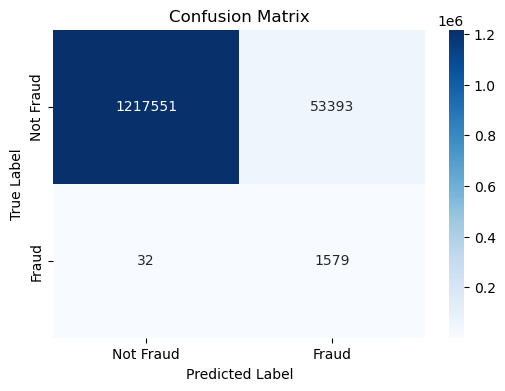

Accuracy: 0.9580


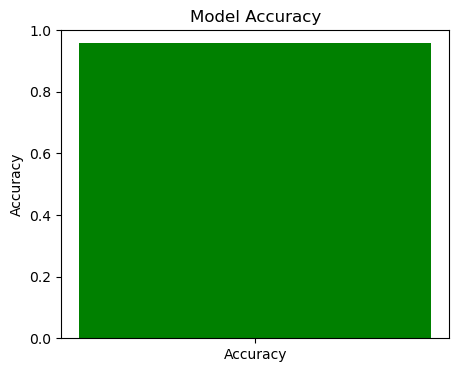

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score

# Convert the predictions to a Pandas DataFrame for easier manipulation
predictions_pandas = predictions.select("isFraud", "prediction").toPandas()

# Extract true labels and predictions
y_true = predictions_pandas['isFraud']
y_pred = predictions_pandas['prediction']

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix using seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Plot accuracy graph (optional)
plt.figure(figsize=(5, 4))
plt.bar(['Accuracy'], [accuracy], color='green')
plt.ylim(0, 1)
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.show()
